**Task - 1**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet152(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 187MB/s]  


In [3]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

In [5]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [6]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_ds   = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

def evaluate(loader, model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_sum / len(loader), correct / total

In [10]:
epochs = 3
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(train_loader, model)
    val_loss, val_acc = evaluate(val_loader, model)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 0.4561, Acc: 0.8449 | Val Loss: 0.4901, Acc: 0.8324
Epoch 2 | Train Loss: 0.4298, Acc: 0.8525 | Val Loss: 0.4738, Acc: 0.8363
Epoch 3 | Train Loss: 0.4168, Acc: 0.8556 | Val Loss: 0.4678, Acc: 0.8386


In [11]:
from torchvision.models.resnet import Bottleneck

def remove_skip(block):
    def forward_no_skip(x):
        out = block.conv1(x)
        out = block.bn1(out)
        out = block.relu(out)

        out = block.conv2(out)
        out = block.bn2(out)
        out = block.relu(out)

        out = block.conv3(out)
        out = block.bn3(out)

        # NO: out += identity
        out = block.relu(out)
        return out

    block.forward = forward_no_skip


In [12]:
for i in [3, 5]:
    remove_skip(model.layer2[i])

In [13]:
epochs = 3
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(train_loader, model)
    val_loss, val_acc = evaluate(val_loader, model)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 2.2489, Acc: 0.2208 | Val Loss: 2.2471, Acc: 0.2232
Epoch 2 | Train Loss: 2.1341, Acc: 0.2574 | Val Loss: 2.1401, Acc: 0.2534
Epoch 3 | Train Loss: 2.0821, Acc: 0.2553 | Val Loss: 2.0861, Acc: 0.2534


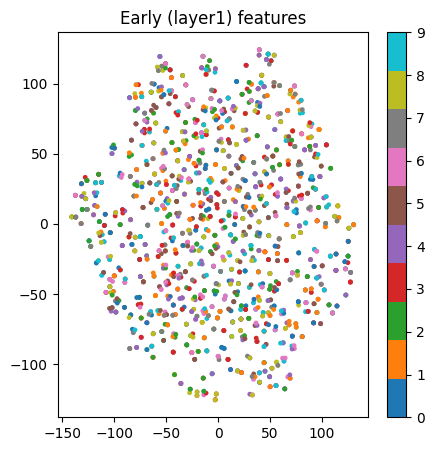

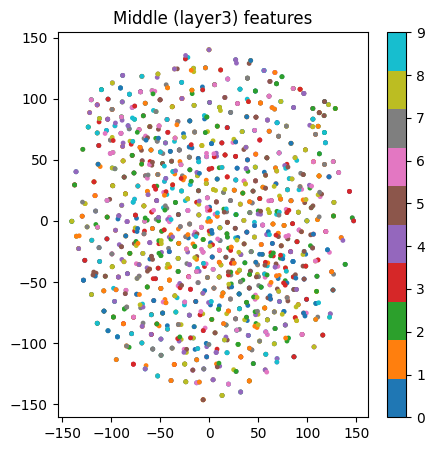

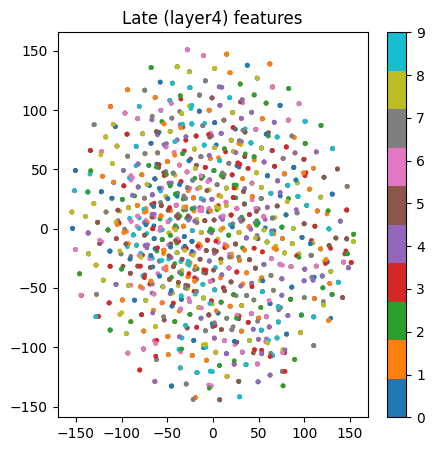

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

ds = datasets.CIFAR10("./data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
early_feats  = []
mid_feats    = []
late_feats   = []
all_labels   = []

def hook_early(m, inp, out):
    early_feats.append(out.mean(dim=(2, 3)).cpu())

def hook_mid(m, inp, out):
    mid_feats.append(out.mean(dim=(2, 3)).cpu())

def hook_late(m, inp, out):
    late_feats.append(out.mean(dim=(2, 3)).cpu())


model.layer1.register_forward_hook(hook_early)
model.layer3.register_forward_hook(hook_mid)
model.layer4.register_forward_hook(hook_late)


MAX_SAMPLES = 2000
count = 0

with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        _ = model(x)

        all_labels.append(y)
        count += x.size(0)
        if count >= MAX_SAMPLES:
            break

labels = torch.cat(all_labels).numpy()
early  = torch.cat(early_feats).numpy()[:MAX_SAMPLES]
mid    = torch.cat(mid_feats).numpy()[:MAX_SAMPLES]
late   = torch.cat(late_feats).numpy()[:MAX_SAMPLES]
labels = labels[:MAX_SAMPLES]


def tsne_plot(feats, labels, title):
    z = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(feats)
    plt.figure(figsize=(5, 5))
    plt.scatter(z[:, 0], z[:, 1], c=labels, s=6, cmap="tab10")
    plt.title(title)
    plt.colorbar()
    plt.show()

tsne_plot(early, labels, "Early (layer1) features")
tsne_plot(mid,   labels, "Middle (layer3) features")
tsne_plot(late,  labels, "Late (layer4) features")

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
val_ds   = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=64)


In [20]:
def train(model, optimizer, epochs=3):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        print(f"Epoch {epoch}: Val Acc = {correct/total:.3f}")


In [21]:
model = models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
train(model, optimizer)


Epoch 0: Val Acc = 0.800
Epoch 1: Val Acc = 0.815
Epoch 2: Val Acc = 0.821


In [24]:
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.SGD(
    list(model.layer4.parameters()) + list(model.fc.parameters()), lr=0.001
)
train(model, optimizer)


KeyboardInterrupt: 

**Task - 2**

In [1]:
pip install torch torchvision transformers pillow requests

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
import requests
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn.functional as F

2026-02-01 17:15:35.809331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769966136.325998      54 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769966136.467902      54 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769966137.730664      54 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769966137.730690      54 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769966137.730693      54 computation_placer.cc:177] computation placer alr

In [28]:
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

model.set_attn_implementation("eager")
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [22]:
import requests
from PIL import Image
from io import BytesIO

def load_image(src):
    
    resp = requests.get(src, timeout=10)
    return Image.open(BytesIO(resp.content)).convert("RGB")


image_sources = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg",
]

images = [load_image(src) for src in image_sources]

In [29]:
inputs = processor(images=images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class_ids = logits.argmax(dim=-1)

In [10]:
for key, class_id in enumerate(predicted_class_ids):
    label = model.config.id2label[class_id.item()]
    print(f"Image {key + 1}: Top-1 Prediction -> {label}")

Image 1: Top-1 Prediction -> Egyptian cat
Image 2: Top-1 Prediction -> bee


In [30]:
inputs = processor(images=images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

logits = outputs.logits
predicted_class_ids = logits.argmax(dim=-1)

In [31]:
attentions = outputs.attentions
print(len(attentions), attentions[0].shape)

12 torch.Size([2, 12, 197, 197])


In [32]:

last_attn = outputs.attentions[-1]

cls_attn = last_attn[:, :, 0, :]
cls_to_patches = cls_attn[:, :, 1:]

print(last_attn.shape)
print(cls_to_patches.shape)

torch.Size([2, 12, 197, 197])
torch.Size([2, 12, 196])


In [33]:
last_attn = outputs.attentions[-1]

cls_attn = last_attn[:, :, 0, :]

cls_to_patches = cls_attn[:, :, 1:]

cls_to_patches_avg = cls_to_patches.mean(dim=1)

print(cls_to_patches_avg.shape)

torch.Size([2, 196])


In [42]:

image_size = 224
patch_size = 16
num_patches_per_dim = image_size // patch_size  
num_patches = num_patches_per_dim ** 2       

attn_vector = cls_to_patches_avg[0].cpu().numpy()

attn_map = attn_vector.reshape(num_patches_per_dim, num_patches_per_dim)

print(attn_map.shape)

(14, 14)


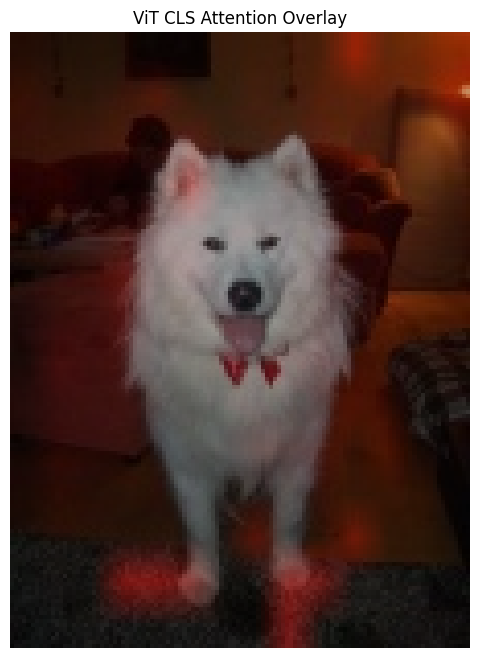

In [41]:


image_source = "https://storage.googleapis.com/cvstock-932a9.appspot.com/thumbnail-Q17HJQ4UAHCJ"
resp = requests.get(image_source, timeout=10)
image = Image.open(BytesIO(resp.content)).convert("RGB")



image_np = np.array(image)
H, W, _ = image_np.shape

image_size = 224
patch_size = 16
num_patches_per_dim = image_size // patch_size

attn_vector = cls_to_patches_avg[0].cpu()
attn_map = attn_vector.reshape(num_patches_per_dim, num_patches_per_dim)

attn_map_np = attn_map.cpu().numpy()

attn_map_img = Image.fromarray(attn_map_np).resize((W, H), resample=Image.BILINEAR)
attn_map_upsampled = np.array(attn_map_img)

attn_map_upsampled = (attn_map_upsampled - attn_map_upsampled.min()) / (attn_map_upsampled.max() - attn_map_upsampled.min())

heatmap = np.zeros_like(image_np)
heatmap[..., 0] = 255 
heatmap = (heatmap * attn_map_upsampled[..., None]).astype(np.uint8)

overlayed = (0.6 * image_np + 0.4 * heatmap).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.imshow(overlayed)
plt.axis('off')
plt.title("ViT CLS Attention Overlay")
plt.show()


plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.title("ViT CLS Attention Overlay")
plt.show()

**Task - 3**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [21]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [22]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(
        recon_x, x, reduction="sum"
    )

    kl_div = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + kl_div, recon_loss, kl_div

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x = x.to(device)

        optimizer.zero_grad()

        recon_x, mu, logvar = model(x)
        loss, recon_l, kl_l = vae_loss(recon_x, x, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss = {avg_train_loss:.4f}, "
        f"Val Loss = {avg_val_loss:.4f}"
    )

Epoch 1/10: 100%|██████████| 422/422 [00:07<00:00, 52.97it/s]


Epoch 1: Train Loss = 42.3377, Val Loss = 29.2426


Epoch 2/10: 100%|██████████| 422/422 [00:07<00:00, 56.59it/s]


Epoch 2: Train Loss = 27.7423, Val Loss = 27.2234


Epoch 3/10: 100%|██████████| 422/422 [00:07<00:00, 56.12it/s]


Epoch 3: Train Loss = 26.2195, Val Loss = 25.8942


Epoch 4/10: 100%|██████████| 422/422 [00:07<00:00, 56.31it/s]


Epoch 4: Train Loss = 25.4079, Val Loss = 25.1698


Epoch 5/10: 100%|██████████| 422/422 [00:07<00:00, 55.95it/s]


Epoch 5: Train Loss = 24.9686, Val Loss = 24.9296


Epoch 6/10: 100%|██████████| 422/422 [00:07<00:00, 55.83it/s]


Epoch 6: Train Loss = 24.6392, Val Loss = 24.6223


Epoch 7/10: 100%|██████████| 422/422 [00:07<00:00, 55.66it/s]


Epoch 7: Train Loss = 24.3944, Val Loss = 24.3824


Epoch 8/10: 100%|██████████| 422/422 [00:07<00:00, 56.46it/s]


Epoch 8: Train Loss = 24.1564, Val Loss = 24.1936


Epoch 9/10: 100%|██████████| 422/422 [00:07<00:00, 56.35it/s]


Epoch 9: Train Loss = 24.0379, Val Loss = 24.0118


Epoch 10/10: 100%|██████████| 422/422 [00:07<00:00, 56.65it/s]


Epoch 10: Train Loss = 23.9011, Val Loss = 23.9837


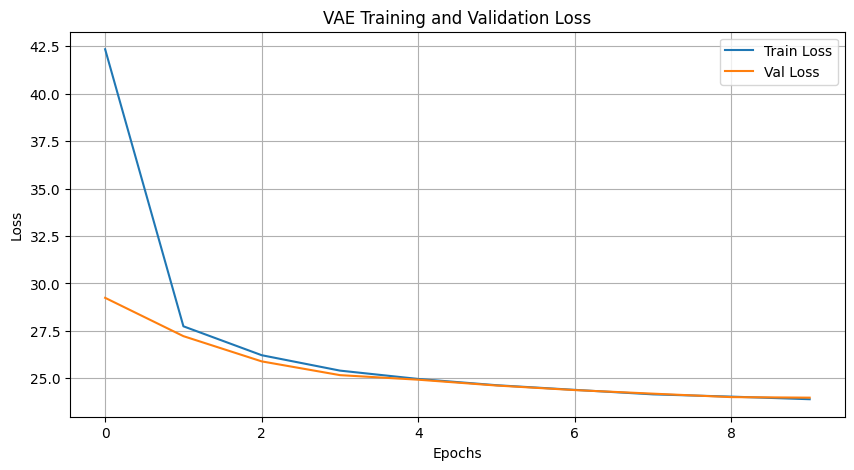

In [5]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [25]:
def show_images(images, nrow=8, figsize=(12,6), title=None):
    images = images.cpu().detach().numpy()
    batch_size = images.shape[0]
    fig, axes = plt.subplots(nrow, int(np.ceil(batch_size / nrow)), figsize=figsize)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    for ax in axes[batch_size:]:
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

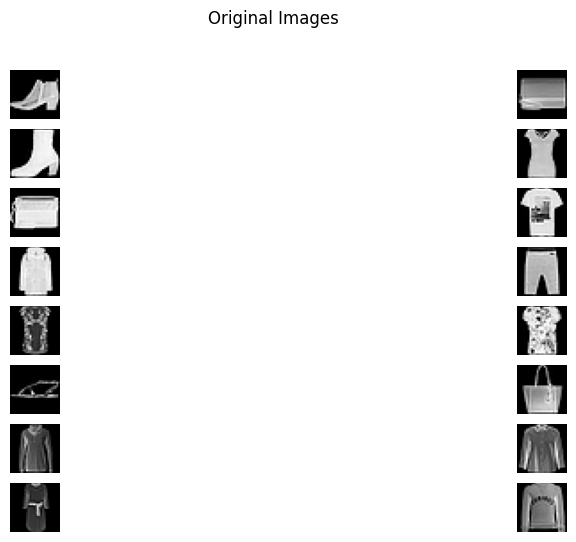

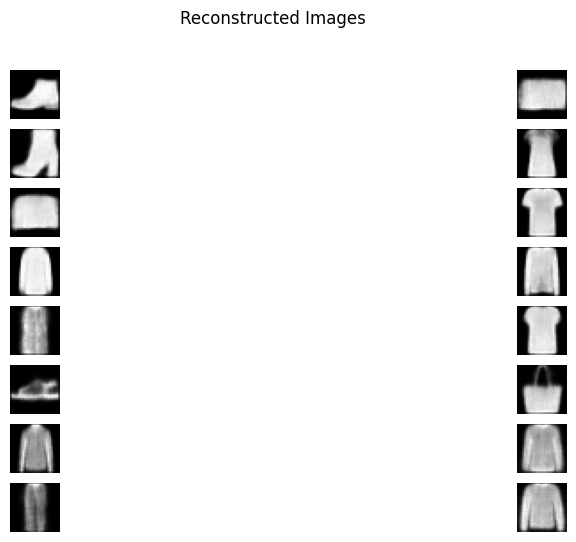

In [26]:
model.eval()
x, _ = next(iter(val_loader))
x = x.to(device)
with torch.no_grad():
    recon_x, _, _ = model(x)

show_images(x[:16], title="Original Images")
show_images(recon_x[:16], title="Reconstructed Images")

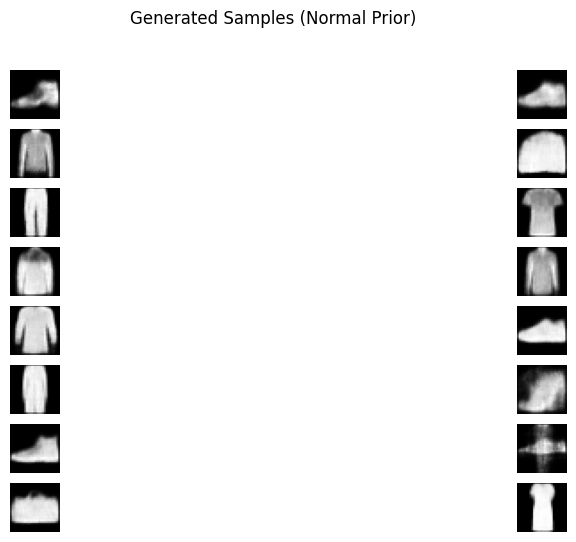

In [6]:
def generate_samples(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Sample z from standard normal distribution
        z = torch.randn(num_samples, 20).to(device) 
        samples = model.decode(z)
        
    show_images(samples, title="Generated Samples (Normal Prior)")

generate_samples(model)

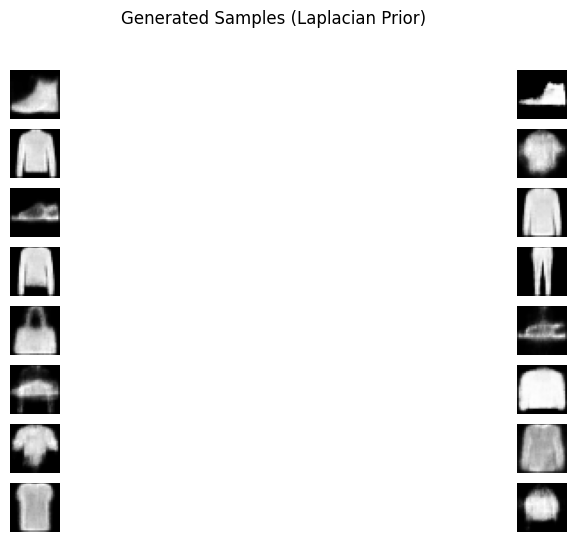

In [7]:
def generate_laplacian_samples(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0]))
        z = m.sample((num_samples, 20)).squeeze().to(device)
        
        samples = model.decode(z)
        
    show_images(samples, title="Generated Samples (Laplacian Prior)")

generate_laplacian_samples(model)

Epoch 1 | Recon: 15.97 | KL: 7.81
Epoch 2 | Recon: 15.87 | KL: 7.83
Epoch 3 | Recon: 15.78 | KL: 7.85
Epoch 4 | Recon: 15.66 | KL: 7.87
Epoch 5 | Recon: 15.60 | KL: 7.89
Epoch 6 | Recon: 15.52 | KL: 7.89
Epoch 7 | Recon: 15.45 | KL: 7.91
Epoch 8 | Recon: 15.39 | KL: 7.92
Epoch 9 | Recon: 15.34 | KL: 7.92
Epoch 10 | Recon: 15.26 | KL: 7.94


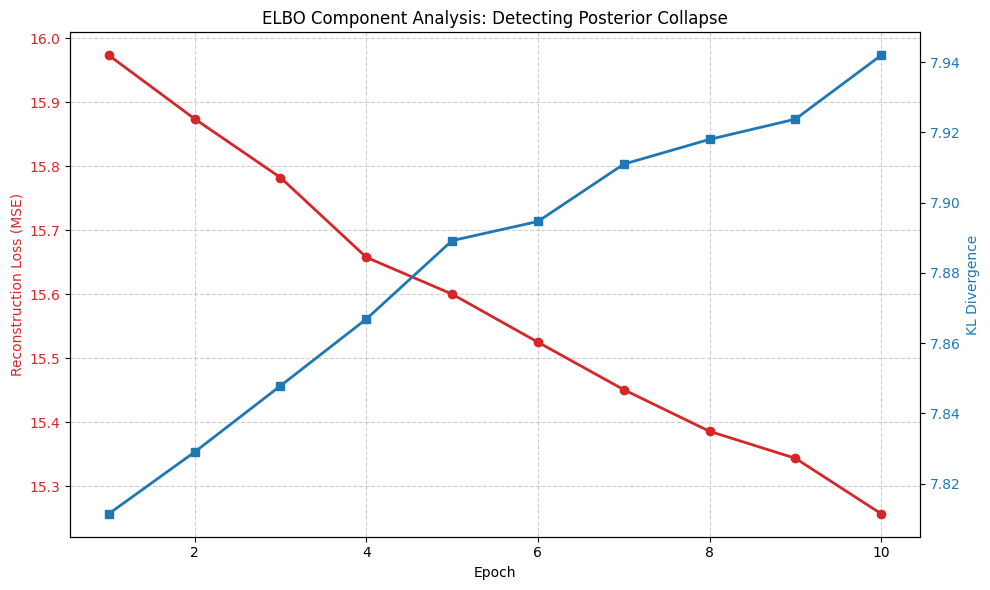

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
history = {
    'epoch': [],
    'train_total': [],
    'train_recon': [],
    'train_kl': [],
    'val_total': []
}

for epoch in range(num_epochs):
    model.train()
    train_total_loss = 0
    train_recon_loss = 0
    train_kl_div = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        recon_x, mu, logvar = model(x)
        loss, r_loss, k_loss = vae_loss(recon_x, x, mu, logvar)

        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_recon_loss += r_loss.item()
        train_kl_div += k_loss.item()

    n = len(train_loader.dataset)
    history['epoch'].append(epoch + 1)
    history['train_total'].append(train_total_loss / n)
    history['train_recon'].append(train_recon_loss / n)
    history['train_kl'].append(train_kl_div / n)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()
    history['val_total'].append(val_loss / len(val_loader.dataset))

    print(f"Epoch {epoch+1} | Recon: {history['train_recon'][-1]:.2f} | KL: {history['train_kl'][-1]:.2f}")

def plot_elbo_analysis(history):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_r = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Reconstruction Loss (MSE)', color=color_r)
    ax1.plot(history['epoch'], history['train_recon'], color=color_r, marker='o', linewidth=2, label='Recon Loss')
    ax1.tick_params(axis='y', labelcolor=color_r)
    ax1.grid(True, linestyle='--', alpha=0.6)

    ax2 = ax1.twinx()
    color_k = 'tab:blue'
    ax2.set_ylabel('KL Divergence', color=color_k)
    ax2.plot(history['epoch'], history['train_kl'], color=color_k, marker='s', linewidth=2, label='KL Divergence')
    ax2.tick_params(axis='y', labelcolor=color_k)

    plt.title('ELBO Component Analysis: Detecting Posterior Collapse')
    fig.tight_layout()
    plt.show()

plot_elbo_analysis(history)

**Task - 4**

In [3]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b8mbd280
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b8mbd280
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ece9a33255e1fe01ae77d71666b25a86065be2ccc70007ee254b2c69d1f8cde9
  Stored in directory: /tmp/pip-ephem-wheel-cache-g44qdmmh/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [4]:
import torch
import clip
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# CLIP preprocessing
model, preprocess = clip.load("ViT-B/32", device=device)

# STL-10 test set
test_dataset = torchvision.datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=preprocess
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

class_names = test_dataset.classes
print(class_names)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 94.7MiB/s]
100%|██████████| 2.64G/2.64G [01:59<00:00, 22.0MB/s] 


['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
prompts_plain = [cls for cls in class_names]

In [9]:
prompts_simple = [f"a photo of a {cls}" for cls in class_names]

In [10]:
prompts_descriptive = [
    f"a high quality photo of a {cls}, a type of object in the real world"
    for cls in class_names
]

In [11]:
def zero_shot_accuracy(prompts):
    with torch.no_grad():
        text_tokens = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = image_features @ text_features.T
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [12]:
acc_plain = zero_shot_accuracy(prompts_plain)
acc_simple = zero_shot_accuracy(prompts_simple)
acc_descriptive = zero_shot_accuracy(prompts_descriptive)

print(f"Plain labels accuracy: {acc_plain:.2f}%")
print(f"Simple prompt accuracy: {acc_simple:.2f}%")
print(f"Descriptive prompt accuracy: {acc_descriptive:.2f}%")

100%|██████████| 125/125 [00:09<00:00, 12.70it/s]

Plain labels accuracy: 96.26%
Simple prompt accuracy: 97.36%
Descriptive prompt accuracy: 96.40%


In [14]:
import torch
import clip
import torchvision
from torch.utils.data import DataLoader, Subset
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load STL-10 test set
dataset = torchvision.datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=preprocess
)

# Take a subset of 100 samples
indices = np.random.choice(len(dataset), 100, replace=False)
subset = Subset(dataset, indices)
loader = DataLoader(subset, batch_size=32, shuffle=False)

class_names = dataset.classes

In [21]:
image_embeddings = []
text_embeddings = []
labels = []

with torch.no_grad():
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        # Image embeddings
        img_feat = model.encode_image(images)

        # Text embeddings (class labels)
        texts = [f"a photo of a {class_names[t]}" for t in targets]
        text_tokens = clip.tokenize(texts).to(device)
        txt_feat = model.encode_text(text_tokens)

        image_embeddings.append(img_feat.cpu())
        text_embeddings.append(txt_feat.cpu())
        labels.extend(targets.cpu().numpy())

image_embeddings = torch.cat(image_embeddings).numpy()
text_embeddings = torch.cat(text_embeddings).numpy()
labels = np.array(labels)

In [22]:
from sklearn.manifold import TSNE
import numpy as np

# Normalize (important)
img_norm = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
txt_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Combine embeddings
all_embeddings = np.vstack([img_norm, txt_norm])

# Single t-SNE fit
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
all_2d = tsne.fit_transform(all_embeddings)

# Split back
img_2d = all_2d[:len(img_norm)]
txt_2d = all_2d[len(img_norm):]

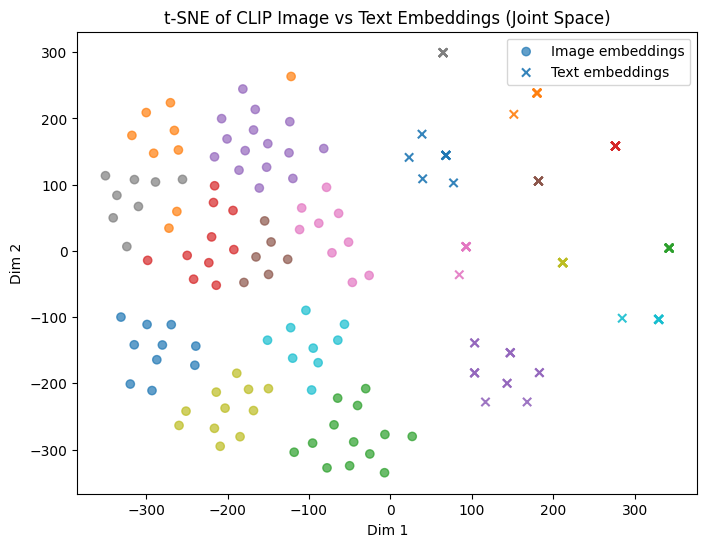

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    img_2d[:, 0], img_2d[:, 1],
    c=labels, cmap="tab10", marker="o", alpha=0.7, label="Image embeddings"
)

plt.scatter(
    txt_2d[:, 0], txt_2d[:, 1],
    c=labels, cmap="tab10", marker="x", alpha=0.9, label="Text embeddings"
)

plt.legend()
plt.title("t-SNE of CLIP Image vs Text Embeddings (Joint Space)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [42]:
image_embeddings = []
text_embeddings = []
labels = []

with torch.no_grad():
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        # Image embeddings
        img_feat = model.encode_image(images)

        # Text embeddings (class labels)
        # Class-level prompts (1 text embedding per class)
        class_level_texts = [f"a photo of a {cls}" for cls in class_names]
        class_labels = list(range(len(class_names)))  # 0–9

        # Instance-level prompts (unique per image)
        instance_level_texts = [
            f"a photo of a {class_names[t]} in a real-world setting" for t in labels
        ]
        text_tokens = clip.tokenize(instance_level_texts).to(device)
        txt_feat = model.encode_text(text_tokens)

        image_embeddings.append(img_feat.cpu())
        text_embeddings.append(txt_feat.cpu())
        labels.extend(targets.cpu().numpy())

image_embeddings = torch.cat(image_embeddings).numpy()
text_embeddings = torch.cat(text_embeddings).numpy()
labels = np.array(labels)

In [43]:
with torch.no_grad():
    txt_class = model.encode_text(
        clip.tokenize(class_level_texts).to(device)
    ).cpu().numpy()

In [44]:
img_n = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
txt_n = txt_class / np.linalg.norm(txt_class, axis=1, keepdims=True)

combined = np.vstack([img_n, txt_n])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(combined)

img_2d = proj[:len(img_n)]
txt_2d = proj[len(img_n):]

In [45]:
img_2d_cls, txt_2d_cls = project_tsne(image_embeddings, txt_class)
img_2d_inst, txt_2d_inst = project_tsne(image_embeddings, txt_instance)

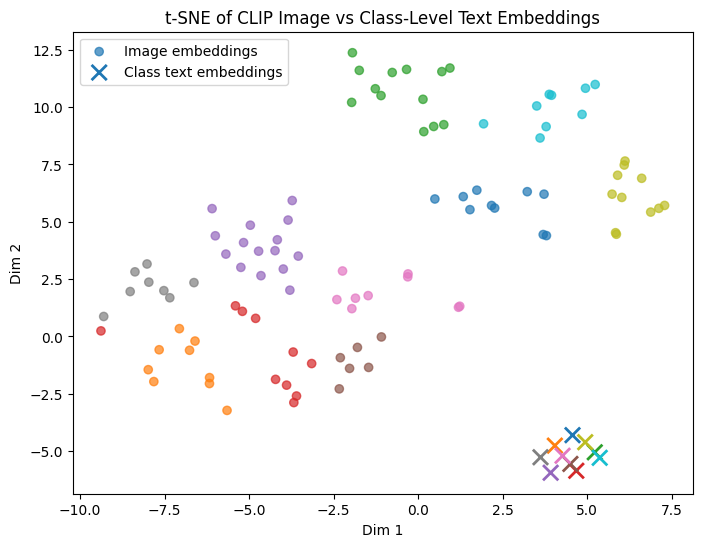

In [46]:
plt.figure(figsize=(8, 6))

plt.scatter(
    img_2d[:, 0], img_2d[:, 1],
    c=labels, cmap="tab10", alpha=0.7, label="Image embeddings"
)

plt.scatter(
    txt_2d[:, 0], txt_2d[:, 1],
    c=class_labels, cmap="tab10", marker="x",
    s=120, linewidths=2, label="Class text embeddings"
)

plt.legend()
plt.title("t-SNE of CLIP Image vs Class-Level Text Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

/tmp/ipykernel_55/2424591364.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(txt_2d_aligned[:, 0], txt_2d_aligned[:, 1],


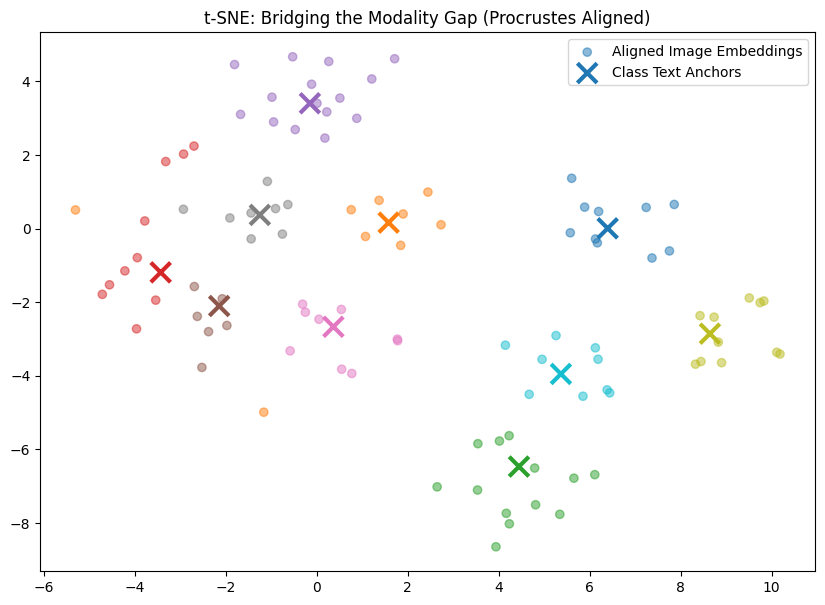

Part (f) Results:
Raw Accuracy:     99.00%
Aligned Accuracy: 100.00%


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from sklearn.manifold import TSNE

# --- Part (b): Pair STL-10 image embeddings with corresponding text ---
# X: Image features, Y: The specific text embedding target for each image
X = img_n 
Y = txt_n[labels] 

# --- Part (c): Learn the optimal rotation matrix R ---
# orthogonal_procrustes finds the best R to minimize ||XR - Y||_F
R, _ = orthogonal_procrustes(X, Y)

# --- Part (d): Apply the rotation transform ---
img_aligned = X @ R

# --- Part (e): Visualize with t-SNE ---
# We combine the aligned images and the original class text embeddings
combined_aligned = np.vstack([img_aligned, txt_n])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj_aligned = tsne.fit_transform(combined_aligned)

# Split the 2D projections back out
img_2d_aligned = proj_aligned[:len(img_aligned)]
txt_2d_aligned = proj_aligned[len(img_aligned):]

# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(img_2d_aligned[:, 0], img_2d_aligned[:, 1], 
            c=labels, cmap="tab10", alpha=0.5, label="Aligned Image Embeddings")

plt.scatter(txt_2d_aligned[:, 0], txt_2d_aligned[:, 1], 
            c=range(len(txt_n)), cmap="tab10", marker="x", s=200, 
            edgecolors='black', linewidths=3, label="Class Text Anchors")

plt.title("t-SNE: Bridging the Modality Gap (Procrustes Aligned)")
plt.legend()
plt.show()

# --- Part (f): Recompute Classification Accuracy ---
def get_accuracy(imgs, texts, gt_labels):
    # Cosine similarity via dot product (since features are normalized)
    scores = imgs @ texts.T 
    preds = np.argmax(scores, axis=1)
    return np.mean(preds == gt_labels) * 100

acc_raw = get_accuracy(img_n, txt_n, labels)
acc_aligned = get_accuracy(img_aligned, txt_n, labels)

print(f"Part (f) Results:")
print(f"Raw Accuracy:     {acc_raw:.2f}%")
print(f"Aligned Accuracy: {acc_aligned:.2f}%")